<font size=6>**Machine Learning Practises - Workshop**</font>

# Hyper-parameter tuning

"**Tuning**" refers to the procedure of selecting the best hyper-parameters for a model.

What "**best**" means?  As usual, the ones which return the best metric of performance on the validation set.

For example, let's take the Random Forests **classifier**. Its <code>sklearn</code> implementation has 10 tunable hyperparameters (plus a few more that are related to the computational execution):

In [1]:
import inspect
from sklearn.ensemble import RandomForestClassifier

models = [RandomForestClassifier]

for m in models:
    hyperparams = inspect.signature(m.__init__)
    print(hyperparams)

(self, n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


Let's make it more complicated: let's add some preprocessing, which become part of the pipilene.

So now the model is not just the classifier, but:

> **Model** = **preprocessing + classifier**.

Recall that in general, a model contains _all_ the steps that go from the **input** to the **output** and that must be trained concurrently (**golden rule**):

<table><tr>
    <td width=640>
        <img src="images/Model.jpg">
        <center>
            <br>
            Figure 1.A.  A generic model template, containing several other steps apart from the Classifier.
            <br>
        </center>
    </td>
    <td width=256>
        <img src="images/I_Am_The_Model_Now.jpg">
        <center>
            <br>
            Figure 1.B.  Don't mess with the model.
            <br>
        </center>
    </td>
</tr></table>

Our preprocessing will be a **Principal Component** dimensionality reduction.

This also has an hyperparameter: the number of dimensions ($n_{dim}$) we want to reduce to.

How do we account for this?  We can do it simply by creating a **hyperparameter array**:

<table><tr>
    <td width=640>
        <img src="images/Model_Hyperparameters.jpg">
        <center>
            <br>
            Figure 2.  Hyperparameters for the generic model template shown above.
            Individual steps might be switched on/off by creating a proxy
            hyperparameter
            that can take a value of 1 if the specific step is used, or 0 if not.
            <br>
        </center>
    </td>
</tr></table>

NOTATION WARNING:

We can see these names used interchangeably, but their $un$-ambiguous definitions would be:

> - **configuration**: a specific set of hyperparameters (_defines which algorithms we pick and their tuning_)
> - **model**: a fitted configuration (_the same configuration trained on 2 different sets give birth to 2 different models_)
> - **learning method**: the procedure of finding the best-fitting model (_the "master" model_)

## Building the model

We can assemble the Model using [<code>sklearn.pipeline</code>](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):

In [193]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

model = Pipeline([('PCA', PCA()), ('RFC', RandomForestClassifier())])

model

Pipeline(steps=[('PCA', PCA()), ('RFC', RandomForestClassifier())])

## Getting the data

Let's generate some synthetic data to play with.

In [194]:
from sklearn.datasets import make_classification
from prettytable import PrettyTable
import numpy as np
import pandas as pd

X, y = make_classification(n_samples=300, n_features=10, n_informative=7,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1, weights=None, flip_y=0.01,
                           class_sep=0.5, hypercube=True, shift=0.0, scale=1.0,
                           shuffle=True, random_state=42)

table = PrettyTable()
table.title = str('Data shape')
table.field_names = ['X', 'y']
table.add_row([np.shape(X), np.shape(y)])
print(table)

+--------------------+
|     Data shape     |
+-----------+--------+
|     X     |   y    |
+-----------+--------+
| (300, 10) | (300,) |
+-----------+--------+


In [195]:
# Splitting the sample for training and test:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

table = PrettyTable()
table.title = str('Data shape')
table.field_names = ['set', 'X', 'y']
table.add_row(['train', np.shape(X_train), np.shape(y_train)])
table.add_row(['test',  np.shape(X_test),  np.shape(y_test)])
print(table)

+----------------------------+
|         Data shape         |
+-------+-----------+--------+
|  set  |     X     |   y    |
+-------+-----------+--------+
| train | (210, 10) | (210,) |
|  test |  (90, 10) | (90,)  |
+-------+-----------+--------+


## Fitting and tuning the hyperparameters

We will use **Cross Validation** with an **hold-out** set for the testing:

<table><tr>
    <td width=640>
        <img src="images/CV_holdout_split.png">
        <center>
            <br>
            Figure 3. Hold-out split.
            <br>
        </center>
    </td>
</tr></table>

We will evaluate the average performance of **each configuration** over the folds.

The **best** configuration will be the one yielding the best average performance.

<table><tr>
    <td width=640>
        <img src="images/CV_k4_hyperpar.jpg">
        <center>
            <br>
            Figure 4. Cross Validation protocol, which will be applied to each configuration.
            <br>
        </center>
    </td>
</tr></table>

NOTE: In practice, we proceed it in this way:

1. We perform the first split into $k$ folds
2. We fit all models on the training folds, and record their performance on the validation fold
3. We repeat for the next split, until all possible splits are performed

### Hyperparameter search strategy

But which strategy shall we choose to explore the hyperparameter space? <br>
I.e., which parameter configurations shall we check?

The hyperparameter space is potentially infinite.

One simple approach (and surprisingly effective!) is the:
> **Random Search**: Try randomly drawn parameter configurations until a pre-determined time limit

Here we will try the [<code>sklearn GridSearchCV</code>](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):

> **Grid Search**: Set a range for the parameters and exhaustively search within it

First, we define the parameter limits:

In [202]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    "PCA__n_components": [2, 3, 5, 8],
    "RFC__n_estimators": [10, 20, 50, 100],
    "RFC__max_depth": np.arange(2, 10, 2),
}
'''
The syntax of this dictionary is:
    <label_as_you_defined_in_pipe>__<parameter_name_as_in_sklearn_documentation>
Type, e.g.:
    RandomForestClassifier?
to visualize all the possible parameters    
''';

display(param_grid)

{'PCA__n_components': [2, 3, 5, 8],
 'RFC__n_estimators': [10, 20, 50, 100],
 'RFC__max_depth': array([2, 4, 6, 8])}

We created a grid over 3 hyperparameters (and let the rest to keep the default values), and sampled only 4 values for each of them.

Keep in mind that the Grid Search is extremely time consuming.

NOTE: See the [<code>sklearn</code> tutorial](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html) on how to combine a Grid Search with a pipeline model.


Let's now implement the search strategy, including the Cross Validation:

In [203]:
search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy',
                      n_jobs=-1, refit=True, return_train_score=True)
'''
Read this as:
    "Perform a Grid Search on Model <model> creating the configurations using
    the parameter grid <param_grid>, and Cross Validation with 5 folds.
    Use accuracy to evaluate the configurations.
    
refit = True
    Will refit the best found model on the whole dataset, which is the actual
    model we shall use for prediction on unseen data!
    By doing that, after the training is complete, we can just predict by 
    using the standard sklearn syntax:
    
        yhat = search.best_estimator_predict(X)
''';

### Fitting the Model

This uses the usual <code>sklearn</code> syntax, but on the <code>search</code> object.

In [204]:
%%time
search.fit(X_train, y_train)
# NOTE: We pass the whole dataset, the CV fold splitting is done internally!

print("Best configuration (mean CV score = %0.3f):" % search.best_score_)
# NOTE: The best configuration is the one with the best _mean_ score across
#       folds, not the one with the absolute best score

print(search.best_params_)

Best configuration (mean CV score = 0.867):
{'PCA__n_components': 8, 'RFC__max_depth': 6, 'RFC__n_estimators': 10}
CPU times: user 394 ms, sys: 8.35 ms, total: 403 ms
Wall time: 4.32 s


### Estimating the model accuracy, the wrong way

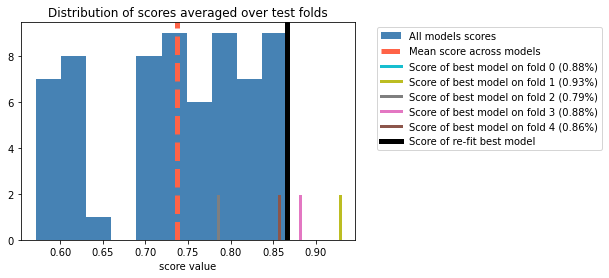

In [205]:
# > Check distribution of the scores

# GridSearch stores the test scores across the folds under the
# "mean_test_score" entry of the trained <search.cv_results_> dictionary.
# They are indexed by configuration, e.g., entry 0 refers to configuration 0

mean_test_scores = search.cv_results_['mean_test_score']
# mean scores across test sets (== validation sets, in the case of CV), one per model

best_score_folds = [search.cv_results_['split'+str(i)+'_test_score'][search.best_index_] for i in range(search.n_splits_)]
# all scores of best model, one per fold

# Let's plot the histogram of the scores obtained by each model:
# NOTE: The score of a model is itself averaged over the k validation folds

from matplotlib import pyplot as plt

plt.title('Distribution of scores averaged over test folds')
plt.hist(mean_test_scores, color='steelblue', label='All models scores')
plt.axvline(x=np.mean(mean_test_scores), lw=5, ls='--', c='tomato', label='Mean score across models')

cmap = plt.cm.get_cmap('tab10_r', 10)
for i, best_score_fold in enumerate(best_score_folds):
    plt.axvline(x=best_score_fold, ymin=0, ymax=0.2, lw=3, ls='-', c=cmap(i), \
                label='Score of best model on fold %s (%.2f%%)' % (str(i), best_score_fold))
plt.axvline(x=search.best_score_, lw=5, ls='-', c='black', \
            label='Score of re-fit best model')

plt.xlabel('score value')
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()

_Overconfident much, aren't we?!_ $\rightarrow$ Winner's curse

NOTE: The "**best score**" is the one of the best model re-fit on the whole dataset.

## EXERCISE 1.1:  Estimate the true accuracy on the test set

Estimate the accuracy on the best model on the test set, in 2 ways:
- Applying the best, re-fitted model, on the whole test set
- Creating a distribution of accuracies by bootstrapping the test set

 <u>Hint:</u><br>
 To create 1 bootstrapped sample, you can sample the indices of $X_{test}$ using <code>np.random.choice</code>, and set its <code>replace</code> parameter to <code>True</code>.

In [206]:
import sklearn.metrics
print("Accuracy score on test set: %.2f%%" % sklearn.metrics.accuracy_score(y_test, search.predict(X_test)))

Accuracy score on test set: 0.81%


We would like to have a distribution of accuracies.  But we have a small test set: if we split it, we will not have enough samples in each split. 

We will use **bootstrapping** (sampling with replacement)!

Bootstrapping allows to create an arbitrary number of sets from a "source" set.<br>
In this way, we can measure the accuracy multiple times, and hence look at its distribution.

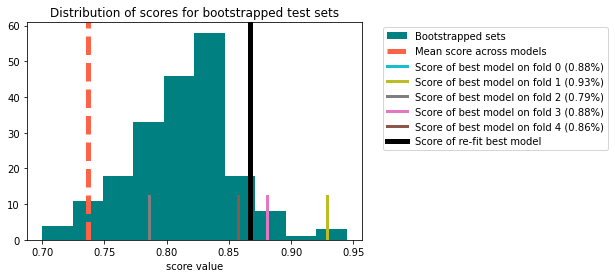

In [207]:
# Predicting labels of test set:
import sklearn.metrics
import numpy as np

n_bs = 200
# number of desired bootstrapped sets
size_bs = len(X_test)
# size of a bootstrapped set (same as X_test)
scores_bs = [0] * n_bs
# list of bootstrapped scores, one per bootstrapped set

np.random.seed(42)

for i in range(n_bs):
    
    # Bootstrapping a set of indexes:
    idxs_bs = np.random.choice(np.arange(size_bs), size=size_bs, replace=True)
    # Bootstrapped set, selected by the bootstrapped indexes:
    X_test_bs = X_test[idxs_bs]
    y_test_bs = y_test[idxs_bs]

    # Predict labels of bootstrapped set using the best fit model:
    yhat_test_bs = search.predict(X_test_bs)
    
    # Recording the score for this bootstrapped sample:
    scores_bs[i] = sklearn.metrics.accuracy_score(y_test_bs, yhat_test_bs)

best_score_CV = search.best_score_

# Plotting bootstrapped distribution:
from matplotlib import pyplot as plt

plt.title('Distribution of scores for bootstrapped test sets')
plt.hist(scores_bs, color='teal', label='Bootstrapped sets')
plt.axvline(x=np.mean(mean_test_scores), lw=5, ls='--', c='tomato', label='Mean score across models')

cmap = plt.cm.get_cmap('tab10_r', 10)
for i, best_score_fold in enumerate(best_score_folds):
    plt.axvline(x=best_score_fold, ymin=0, ymax=0.2, lw=3, ls='-', c=cmap(i), \
                label='Score of best model on fold %s (%.2f%%)' % (str(i), best_score_fold))
plt.axvline(x=best_score_CV, lw=5, ls='-', c='black', \
            label='Score of re-fit best model')

plt.xlabel('score value')
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()

<u>Conclusions:</u>

When performing **fitting** <u>**+ hyperparameter tuning**</u>:

- The validation set(s) can only be used to **select** the best configuration.

- You _cannot_ use the validation set to select the hyperparameters **and** report the performance!

- To assess the performance, you need a **test set**.

  Or else you are gonna bias the estimation!

# Model selection

This is conceptually not much different from the example we saw above.

The line between **hyperparameter tuning** and model **model selection** is very thin, since $-$as we have seen $-$ a model can be seen as a configuration which might "switch" _on_ or _off_ a specific algorithm.

For the sake of simplicity, in this section we will only try to select among different **classifiers** (we forget about all the other processing).

<u>Unbiased estimations</u>

In general, we would like a learning method for selecting the best model and fitting, which is not biased in its performance estimation:
- If we have many, many data $\rightarrow$ Use a hold-out set

- If we have few data, need to cycle through $\rightarrow$ Enter **Nested Cross Validation (NCV)**!

<u>How NCV works</u>

In the basic CV, we didn't have a test set to independently estimate the selected model performance.

So why not add one more **outer** cross-validation which isolates a test set at each split?!

<table><tr>
    <td width=640>
        <img src="images/NCV_k4.jpg">
        <center>
            <br>
            Figure 5. Nested Cross Validation protocol.
            <br>
        </center>
    </td>
</tr></table>

Basically, NCV cross-validates the CV!

Now, we can think the NCV as a whole as _the_ **learning method**.

- As an **input**, it takes the data
- **Inside**, it learns to select the best model
- As an **output**, it returns the best model and the performance estimations on the outer loop

<table><tr>
    <td width=640>
        <img src="images/NCV_learning_method.jpg">
        <center>
            <br>
            Figure 6. Nested Cross Validation as a learning method.
            <br>
        </center>
    </td>
</tr></table>

<u>Important Notice</u>

This sounds overinterpreted, but it's not!

Notice how the model (configuration) selected by each CV can be different!
 
That means that the output distribution of performances is generated by different fitted algorithms!
It does _not_ refer to the specific best configuration!
 
In practice, the actual configuration of the final model is not so relevant, what is relevant is that <u>we can fit the input data with <_this much_> accuracy</u>.
<br>

<details>
<summary><b>[Spoiler]</b></summary>
<table><tr>
    <td width=400>
        <img src="images/Model_Not_Important.jpg">
    </td>
</tr></table>
</details>

Some useful links before we start:

[ - ] NCV with [<code>sklearn</code>](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)

[ - ] A marvellous [introductive guide](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/) by J. Brownlee

[ - ] Final model: better retrain on the **best** configuration, or on an **ensamble** of the best inner models?
See the considerations [here](https://www.analyticsvidhya.com/blog/2021/03/a-step-by-step-guide-to-nested-cross-validation/).

## Let's try NCV to select among classifiers


Two nice methods to implement CV for multpile classifiers can be found [here](https://stackoverflow.com/questions/23045318/grid-search-over-multiple-classifiers).

In [148]:
from termcolor import colored, cprint
# NCV utilities:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from pipelinehelper import PipelineHelper
from collections import OrderedDict
# Scalers:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
# Classifiers:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
# Metrics:
import sklearn.metrics
# Ignore sklearn warnings (remove when ready!):
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [125]:
# Nested CV setup variables --------------------------------------------------
n_splits_outer = 5
# number of folds in outer CV 
n_splits_inner = 3
# number of folds in inner CV 
#-----------------------------------------------------------------------------

In [128]:
def inner_CV(X_train, y_train, n_splits_inner, verbose=0):
    '''
    Inner CV loop, implemented using PipelineHelper: 
        https://github.com/bmurauer/pipelinehelper
        
    Parameters:
    -----------
    X_train, y_train : np.ndarray, np.array
        Data over which to perform the inner CV.
    n_splits_inner : int
        Number of k-folds for the inner loop.
    '''
    
    '''Define here all possible models that you want to attemp:
    
        In particular, this pipeline trains, for each CV iteration, one
        combination of:
       - a scaler (sampled between StandardScaler or MaxAbsScaler)
       - a classifier (sampled between LinearSVC or RandomForestClassifier)
    '''
    
    models = Pipeline([
        ('scaler', PipelineHelper([
            ('std', StandardScaler()),
            ('max', MaxAbsScaler()),
        ])),
        ('classifier', PipelineHelper([
            ('svm', LinearSVC()),
            ('rf', RandomForestClassifier()),
        ])),
    ])

    '''Define here the parameter you want to sample, for each scaler
    and each classifier:
    
        In particular, this pipeline tries:
        - using mean and/or standard deviation to scale the data
        - different C parameters for the Support Vector machine Classifier 
        - different n_estimators for the Random Forsests
        
        NOTE1: MaxAbsScaler takes no parameters!
        NOTE2: You can just through in all the parameters, the PipelineHelper
               will take care to attribute them to the correct algorithm
    '''
    
    param_grid = {
        'scaler__selected_model': models.named_steps['scaler'].generate({
            'std__with_mean': [True, False],
            'std__with_std': [True, False],
            'max__copy': [True],  # just for displaying
        }),
        'classifier__selected_model': models.named_steps['classifier'].generate({
            'svm__C': [0.1, 1.0],
            'rf__n_estimators': [100, 20],
        })
    }
    
    search = GridSearchCV(models, param_grid, scoring='accuracy',
                        cv=n_splits_inner, refit=True, verbose=verbose)

    result = search.fit(X_train, y_train)
    # NOTE: After GridSearch finds the best model, it re-fits it on the whole
    #       X_train set and returns it as the best model
    
    return result

In [151]:
%%time

# Configuring the outer CV procedure:
cv_outer = KFold(n_splits=n_splits_outer, shuffle=True, random_state=42)

outer_models = OrderedDict()
# dictionary of best models found at each outer iteration <indexed by outer CV iteration>

for i, (train_ix, test_ix) in enumerate(cv_outer.split(X_train)):
# outer CV loop
# NOTE: We will only use the training set for the NCV, and further split it.
#       We want to keep the hold-out set for the final check!
    
    cprint('> Outer iteration %s [of %s]' % (i+1, n_splits_outer), 'red')
    
    # Splitting outer CV data in train and test:
    X_outer_train, X_outer_test = X_train[train_ix, :], X_train[test_ix, :]
    y_outer_train, y_outer_test = y_train[train_ix]   , y_train[test_ix]
    
    # > Executing the search (i.e., the inner CV loop):
    result = inner_CV(X_outer_train, y_outer_train, n_splits_inner)
    # NOTE: Inside the inner CV, X_outer_train will be further split in the
    #       inner train and validation sets by GridSearchCV
    
    # Getting the best performing model:
    best_model = result.best_estimator_
    
    # > Evaluating model on the test fold
    
    # Predicting test labels:
    yhat_outer_test = best_model.predict(X_outer_test)

    # Scoring the model on test fold:
    score = sklearn.metrics.accuracy_score(y_outer_test, yhat_outer_test)
    
    # Storing score result for current [outer CV] fold:
    outer_models[str(i)] = OrderedDict({  
        'score': score,
        'cfg': result.best_params_
    })

    print('\tScore: valid = %.2f | test = %.2f' % (np.abs(result.best_score_), score))
    print('\tSelected config: %s' % result.best_params_, end='\n\n')

df_outer_models = pd.DataFrame(outer_models).T

# Summarizing the estimated performance of the model:
print()
print('Mean test score: %.3f (+/-%.3f)\n' %
      (np.mean(df_outer_models['score']), np.std(df_outer_models['score'])))

> Outer iteration 1 [of 5]
	Score: valid = 0.85 | test = 0.81
	Selected config: {'classifier__selected_model': ('rf', {'n_estimators': 100}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': True})}

> Outer iteration 2 [of 5]
	Score: valid = 0.83 | test = 0.86
	Selected config: {'classifier__selected_model': ('svm', {'C': 0.1}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': False})}

> Outer iteration 3 [of 5]
	Score: valid = 0.78 | test = 0.83
	Selected config: {'classifier__selected_model': ('svm', {'C': 1.0}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': False})}

> Outer iteration 4 [of 5]
	Score: valid = 0.86 | test = 0.79
	Selected config: {'classifier__selected_model': ('svm', {'C': 0.1}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': True})}

> Outer iteration 5 [of 5]
	Score: valid = 0.83 | test = 0.76
	Selected config: {'classifier__selected_model': ('svm', {'C': 0.1}), 'scaler__selected_model': ('

### Final NCV model

In [153]:
# Picking best configuration
# IMPORTANT: reverse min/max if the selection maximises the score!

print('Outer CV configurations:')
display(df_outer_models)
print('Best configuration:')
display(df_outer_models[df_outer_models['score'] == df_outer_models['score'].max()])

best_config = df_outer_models[df_outer_models['score'] == df_outer_models['score'].min()]['cfg'].values[0]
print(best_config)

Outer CV configurations:


,score,cfg
0,0.809524,"{'classifier__selected_model': ('rf', {'n_esti..."
1,0.857143,"{'classifier__selected_model': ('svm', {'C': 0..."
2,0.833333,"{'classifier__selected_model': ('svm', {'C': 1..."
3,0.785714,"{'classifier__selected_model': ('svm', {'C': 0..."
4,0.761905,"{'classifier__selected_model': ('svm', {'C': 0..."


Best configuration:


,score,cfg
1,0.857143,"{'classifier__selected_model': ('svm', {'C': 0..."


{'classifier__selected_model': ('svm', {'C': 0.1}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': True})}


In [187]:
# Retraining best configuration on all training data:

# LinearSVC(),
# RandomForestClassifier()
#
# StandardScaler(),
# MaxAbsScaler()

cls_params    = best_config['classifier__selected_model'][1]
scaler_params = best_config['scaler__selected_model'][1]

scaler = StandardScaler(scaler_params)
cls    = LinearSVC(**cls_params)

print('Retraining on all training data:')
print('\tScaler:', scaler)
print('\tClassifier:', cls)
print('\t\t', cls_params)

model_NCV = Pipeline([('scaler', scaler), ('cls', cls)])
print(model)

model_NCV.fit(X_train, y_train)

Retraining on all training data:
	Scaler: StandardScaler(copy={'with_mean': True, 'with_std': True})
	Classifier: LinearSVC(C=0.1)
		 {'C': 0.1}
Pipeline(steps=[('scaler',
                 StandardScaler(copy={'with_mean': True, 'with_std': True})),
                ('cls', LinearSVC(C=0.1))])


/data/software/anaconda3/envs/autoML/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass copy={'with_mean': True, 'with_std': True} as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Pipeline(steps=[('scaler',
                 StandardScaler(copy={'with_mean': True, 'with_std': True})),
                ('cls', LinearSVC(C=0.1))])

In [188]:
import sklearn.metrics

# Predicting labels of test set:
yhat_test = model_NCV.predict(X_test)

print("Accuracy score on test set: %.2f%%" % sklearn.metrics.accuracy_score(y_test, yhat_test))

Accuracy score on test set: 0.78%


### True accuracy score on NCV model

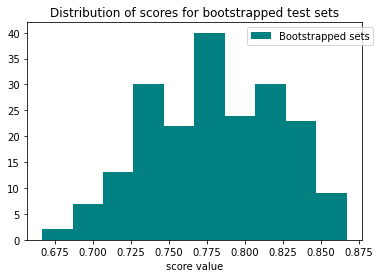

In [209]:
# Predicting labels of test set:
import sklearn.metrics
import numpy as np

n_bs = 200
# number of desired bootstrapped sets
size_bs = len(X_test)
# size of a bootstrapped set (same as X_test)
scores_bs = [0] * n_bs
# list of bootstrapped scores, one per bootstrapped set

np.random.seed(42)

for i in range(n_bs):
    
    # Bootstrapping a set of indexes:
    idxs_bs = np.random.choice(np.arange(size_bs), size=size_bs, replace=True)
    # Bootstrapped set, selected by the bootstrapped indexes:
    X_test_bs = X_test[idxs_bs]
    y_test_bs = y_test[idxs_bs]

    # Predict labels of bootstrapped set using the best fit model:
    yhat_test_bs = model_NCV.predict(X_test_bs)
    
    # Recording the score for this bootstrapped sample:
    scores_bs[i] = sklearn.metrics.accuracy_score(y_test_bs, yhat_test_bs)


# Plotting bootstrapped distribution:
from matplotlib import pyplot as plt

plt.title('Distribution of scores for bootstrapped test sets')
plt.hist(scores_bs, color='teal', label='Bootstrapped sets')

plt.xlabel('score value')
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()

In [ ]:
# https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_nested.html

## How to pick the hyperparameters/algorithms to explore?

The possible varaints one can try when exploring models are potentially very large.<br>
We cannot afford to spend infinite time fitting!

Solutions include:
 - consider previous knowledge of models performance in the learning method (**meta features**)
 - **early dropping** of poorly performing models (_not to fit them at every iteration_)
 - address the whole issue as an **optimization problem**
 
 There are plenty of optimization algorithms, and we leave it up to you to study them.
 
 > A safe all-round bet might be the successful **Bayesian Optimization**: [here](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) you can find a good introduction.

<table><tr>
    <td width=640>
        <img src="images/Know_More.jpg">
        <center>
            <br>
            Figure 7.  Check Bayesian Optimization before the insects take over.
            <br>
        </center>
    </td>
</tr></table>

# Auto ML

> **Auto ML**: Automated hyperparameter search, and model selection, with techniques
    allowing to select which algorithms to try out (_i.e., avoiding extensive search_).

There are many services providing auto ML out there $-$ here we will look at the 
<code>[auto-sklearn](https://automl.github.io/auto-sklearn/master/)</code>
implementation.

In [ ]:
%%time
import autosklearn.classification

# Defining the automl learning method:
automl = autosklearn.classification.AutoSklearnClassifier(
                                ensemble_size=1, time_left_for_this_task=120)
# Fitting (this will take about <time_left_for_this_task> seconds):
automl.fit(X_train, y_train)

In [ ]:
print(automl.sprint_statistics())

# Predicting labels of test set:
import sklearn.metrics

yhat_test = automl.predict(X_test)

print("Accuracy score on test set: %.2f%%" % sklearn.metrics.accuracy_score(y_test, yhat_test))

## Inspecting the best model details

Let's have a look into the model which has been selected out of all the models that the <code>auto-sklearn</code> has tried out.

In [ ]:
from IPython.display import display

print('=== Selected model ===')
display(automl.show_models())

In [ ]:
for model_id, model in automl.show_models().items():
    print('--- Details of the "data_preprocessing" ---')
    display(model['data_preprocessor'].__dict__)
    
    print('--- Details of the "balancing" ---')
    display(model['balancing'].__dict__)
    
    print('--- Details of the "feature_preprocessor" ---')
    display(model['feature_preprocessor'].__dict__)    

## Final remarks on autoML

You can use <code>auto-sklearn</code> almost blindly $-$ but $-$ to understand the results ...

$\rightarrow$ Read the docs!